In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import itertools
import pandas as pd
import random
from collections import Counter
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from tqdm import tqdm
import string
import matplotlib.pyplot as plt

%matplotlib inline

# Read files and put all together

In [3]:
%%time
data_path = '../data/external/joke-dataset/'
reddit_jokes = pd.read_json(data_path + 'reddit_jokes.json')
wocka_jokes = pd.read_json(data_path + 'wocka.json' )
stupid_jokes = pd.read_json(data_path + 'stupidstuff.json')

CPU times: user 1.45 s, sys: 185 ms, total: 1.63 s
Wall time: 1.63 s


In [4]:
reddit_jokes['body'] = reddit_jokes['title'] + '\n' + reddit_jokes['body']
del reddit_jokes['title']
jokes = pd.concat([reddit_jokes['body'], wocka_jokes['body'], stupid_jokes['body']], axis = 0, ignore_index=True)
len(jokes)

208345

# Preprocessing: data selection

In [5]:
# Remove empty texts
jokes = jokes[~(jokes=='')]

# Ensure no nulls and no empty
assert sum(jokes=='')==0
assert sum(jokes.isnull())==0

Number of jokes: 152493


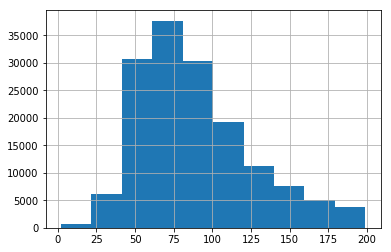

In [6]:
# Remove very long jokes
length_threshold=200
jokes = jokes[jokes.apply(len)<length_threshold]
jokes.apply(len).hist()
print("Number of jokes: %d" %len(jokes))

# Preprocessing: data cleaning

In [7]:
# Lowercase
jokes = jokes.apply(lambda x: x.lower())


In [8]:
# get some samples from the training corpus

for i in range(10):
    print(random.choice(list(jokes)))
    print('-----')

[serious] holocaust jokes are not funny and never will be.
it's a very sore spot for many people. personally, my grandfather died at dachau, he got drunk and fell out of his watchtower.
-----
i'm told i sleep like a baby.
... i wake up crying every few hours
-----
it's international holocaust remembrance day
and fugghedaboütit day in germany.
-----
a giraffe walks into a bar...
and says highballs are on me. 
-----
i don't think i'm ever going to score in asia...
...everyone keeps refusing my tip.
-----
what did the poop say to the pee when he was hitting on her?
i may be a two but your an eight..
-----
what my friend heard in the school hallway.
guy one: i can put windows on any mac laptop.
guy two: i can put mac on any windows laptop.
*third guy shows up*
i can put deez nutz on every laptop.
-----
what do you call a jewish pokemon trainer?
ash
-----
why did the h kill himself?
because the g had.
-----
i went tonthe zoo and all they had was one small dog
and an empty gorilla enclosure.

# Create tokens and encode train and validation set

In [9]:
# Create token_dict based on ascii letters
all_letters = string.ascii_letters[0:26] + """ ".,;'-+=?!$%():\n"""
token_dict = {token:k for token,k in zip(all_letters, range(1,len(all_letters)+1))}

end_token = '<end>'
pad_token = '<pad>'

token_dict[pad_token] = 0
token_dict[end_token] = len(token_dict)

decoder_dict = {token_dict[k]:k for k in token_dict.keys()}
tokens_count = len(token_dict)
assert len(decoder_dict)==len(decoder_dict)
tokens_count

45

In [10]:
def text_encoder(text):
    return [token_dict[token] for token in text if token in token_dict] + [token_dict['<end>']]

%time jokes_encoded =  list( jokes.apply(text_encoder) ) # as a list is much faster to retrieve elements

CPU times: user 1.83 s, sys: 22.1 ms, total: 1.85 s
Wall time: 1.85 s


# Define model

In [11]:
class RNN(nn.Module):
    def __init__(self, 
                 tokens_count,
                 embedding_dimension, 
                 rnn_dim,
                 #relu_dim,
                 num_layers, 
                 dropout):
        
        super(RNN, self).__init__()
        
        self.rnn_dim = rnn_dim
        
        self.embedding = nn.Embedding(tokens_count, embedding_dimension)
        self.lstm = nn.LSTM(input_size = embedding_dimension, 
                            hidden_size = rnn_dim, 
                            num_layers = num_layers, 
                            dropout = dropout,
                            batch_first = True)
        #self.linear_1 =  nn.Linear(rnn_dim , relu_dim) 
        #self.relu_1 = nn.ReLU()
        #self.linear_2 =  nn.Linear(relu_dim , tokens_count)
        #self.relu_2 = nn.ReLU()
        
        self.linear = nn.Linear(rnn_dim,tokens_count)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, inp, seq_length, hidden_states, train=True):
        embedded = self.embedding(inp)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, seq_length, batch_first=True)
        packed_output, (ht, ct) = self.lstm(packed_embedded, hidden_states)
        (lstm_output, length) = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
#         output_linear_1 = self.linear_1(lstm_output)
#         output_relu_1 = self.relu_1(output_linear_1)
#         output_linear_2 = self.linear_2(output_relu_1)
#         output_relu_2 = self.relu_2(output_linear_2)
        
        output_linear = self.linear(lstm_output)
        if train: output = self.dropout(output_linear)
        output = self.softmax(output_linear)
        return output, (ht, ct)

    def initRNN(self, batch_size):
        if use_cuda:
            return (Variable(torch.zeros(num_layers, batch_size, self.rnn_dim).cuda()), 
                Variable(torch.zeros(num_layers, batch_size, self.rnn_dim)).cuda())
        else:
            return (Variable(torch.zeros(num_layers, batch_size, self.rnn_dim)), 
                Variable(torch.zeros(num_layers, batch_size, self.rnn_dim)))


In [12]:
use_cuda = True
embedding_dimension = 1024
num_layers = 3
rnn_dim = 2048
#relu_dim = 256

dropout = 0.1
batch_size = 16

In [13]:
if use_cuda:
    rnn = RNN(tokens_count, embedding_dimension, rnn_dim, num_layers, dropout).cuda()
else:
    rnn = RNN(tokens_count, embedding_dimension, rnn_dim, num_layers, dropout)
loss_function = nn.NLLLoss(ignore_index=token_dict[pad_token])
optimizer = torch.optim.Adam(rnn.parameters())
learning_rate = 0.0005

In [14]:
# Total number of parameters
parameters_count=0
for a in rnn.parameters():
    parameters_count+=len(a)
print("Parameters count: %d" %parameters_count)
rnn.named_parameters

Parameters count: 98439


<bound method Module.named_parameters of RNN(
  (embedding): Embedding(45, 1024)
  (lstm): LSTM(1024, 2048, num_layers=3, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=2048, out_features=45)
  (dropout): Dropout(p=0.1)
  (softmax): LogSoftmax()
)>

In [15]:
def get_lengths(v):
    return np.array([i for i in map(len, v)])

def pad(v):
    lens = np.array([len(item) for item in v])
    mask = lens[:,None] > np.arange(lens.max())
    out = np.zeros(mask.shape,dtype=int)
    out[mask] = np.concatenate(v)
    return out

losses = []
step_count = 0

In [19]:
# load previously trained model
rnn.load_state_dict(torch.load('../models/model.pickle'))

In [45]:
def generates_sequence(start_string, max_length):
    
    input_encoded = []
    for char in start_string:
        input_encoded.append(token_dict[char])

    top_index = 0
    result = start_string
    hidden = rnn.initRNN(1)
    
    if use_cuda:
        input_var =Variable(torch.cuda.LongTensor([input_encoded]))
    else:
        input_var = Variable(torch.LongTensor([input_encoded]))
    
    while input_encoded[0] != token_dict['<end>']:
    
        
        output, hidden = rnn(input_var,
                              np.array([len(input_encoded)]), 
                              hidden ,
                              train = True)

        input_encoded = [int(output.cpu().data.topk(1,dim=2)[1].numpy()[0][-1])]
       
        result+=decoder_dict[input_encoded[0]]
        
        if len(result)==max_length: break
        
        if use_cuda:
            input_var = Variable(torch.cuda.LongTensor(input_encoded)).view(1,1)
        else:
            input_var = Variable(torch.LongTensor(input_encoded)).view(1,1)
        
    return result

print(generates_sequence('bartender said, "knock knock"', 1000))

bartender said, "knock knock"
"who's there?"

"brat"

"bark walker walks into a bar."<end>


In [ ]:
while True:
    random.shuffle(jokes_encoded)
    batches = np.array_split(jokes_encoded, int(len(jokes_encoded)/batch_size))

    for batch in tqdm(batches):

        # Prepare batch input and target (sort and pad)
        batch = list(batch)
        batch.sort(key=len, reverse=True)

        batch_input = [i[:-1] for i in batch]
        batch_target = [i[1:] for i in batch]

        batch_input_pad = pad(batch_input)
        batch_target_pad = pad(batch_target)

        # Forward pass and loss function
        if use_cuda:
            input_var = Variable(torch.cuda.LongTensor(batch_input_pad))
        else:
            input_var = Variable(torch.LongTensor(batch_input_pad))
        
        output, _ = rnn(input_var, get_lengths(batch_input), 
                                  rnn.initRNN(len(batch_input)) ,
                                  train = True)
        flat_output = output.contiguous().view(-1,tokens_count)
        if use_cuda:
            flat_target = Variable(torch.cuda.LongTensor(batch_target_pad.flatten()))
        else:
            flat_target = Variable(torch.LongTensor(batch_target_pad.flatten()))
        loss = loss_function(flat_output , flat_target)  # loss is already averaged
        losses.append(float(loss))
        
        # Optimise
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        step_count+=1
        
#         if step_count%100 == 0:
#             print(generates_sequence(random.choice(string.ascii_letters[0:26]), 500))
#             print('-----')

 13%|█▎        | 1283/9530 [28:09<3:00:59,  1.32s/it]

In [71]:
for i in range(10):
    print(generates_sequence('a dog', 500))
    print('---')

a dog was arrested for salt
the couch was coming out of the closet and said "i don't know what they're saying when i was born in the morning."<end>
---
a dog was walking down the street and saw a man walking down the street...
he said, "i was gonna see your mom a chicken!"<end>
---
a dog walks into a bar...
and says "hey, it's driving me nuts"<end>
---
a dog was walking down the street and saw a man walking down the street...
he said "hey man, i can see your password and the dog should be a dog." the guy says, "no, i just walked out of here and should i see you there."<end>
---
a dog walks into a bar...
and he says "ouch!"<end>
---
a dog walks into a bar...
and the bartender says "why the long face?"<end>
---
a dog walks into a bar...
and says "ouch!"<end>
---
a dog walks into a bar...
and says "i'm looking for the man who shot my paw"<end>
---
a dog was arrested the other day...
he was a man of a bit of a million dollars.<end>
---
a dog walks into a bar...
and he says "i can clearly s

In [80]:
torch.save(rnn.state_dict(), '../models/model.pickle')